In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.cluster.vq import kmeans, vq
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

import skimage
from skimage.util import random_noise

In [2]:
print(skimage.__version__)

0.19.3


(256, 256)


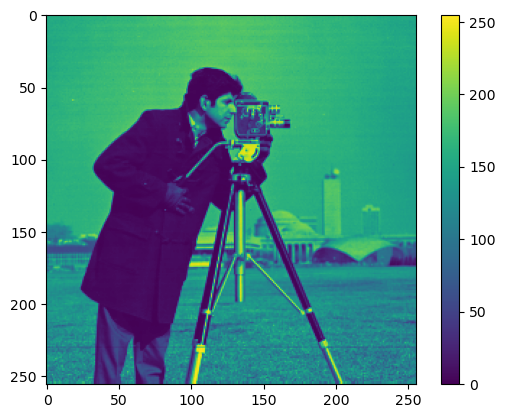

In [3]:
image_number = 3
# dimensionality (N) of subspace = 64
tile_w = 8

image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [4]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

(256, 256)
1.0
255


Text(0.5, 1.0, 'h=3')

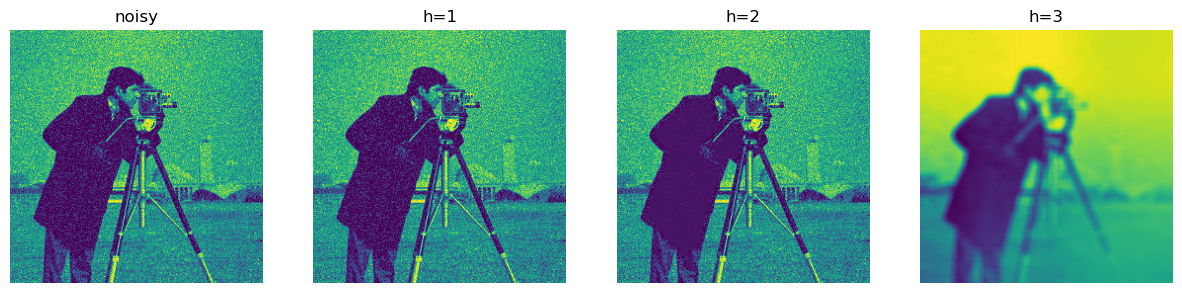

In [5]:
sigma = 0.1
noisy_image = random_noise(image, var=sigma**2)
print(noisy_image.shape)

print(np.max(noisy_image))
noisy_image = cv2.normalize(noisy_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
noisy_image = noisy_image.astype(np.uint8)
print(np.max(noisy_image))

denoised_image1 = cv2.fastNlMeansDenoising(	noisy_image, h=1, templateWindowSize = 8, searchWindowSize = 200	)
denoised_image2 = cv2.fastNlMeansDenoising(	noisy_image, h=10, templateWindowSize = 8, searchWindowSize = 200	)
denoised_image3 = cv2.fastNlMeansDenoising(	noisy_image, h=100, templateWindowSize = 8, searchWindowSize = 200	)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 8),
                       sharex=True, sharey=True)
ax[ 0].imshow(noisy_image)
ax[ 0].axis('off')
ax[ 0].set_title('noisy')
ax[ 1].imshow(denoised_image1)
ax[ 1].axis('off')
ax[ 1].set_title('h=1')
ax[ 2].imshow(denoised_image2)
ax[ 2].axis('off')
ax[ 2].set_title('h=10')
ax[ 3].imshow(denoised_image3)
ax[ 3].axis('off')
ax[ 3].set_title('h=100')
plt.show();

Text(0.5, 1.0, 'iter4')

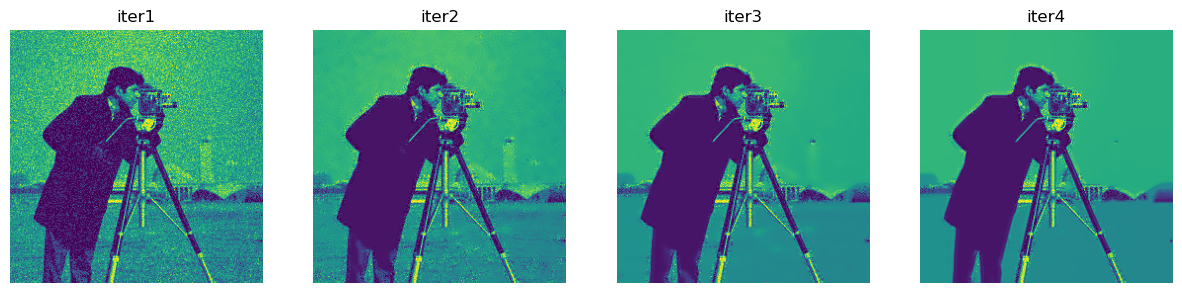

In [6]:
denoised_image2 = cv2.fastNlMeansDenoising(	denoised_image1, h=15, templateWindowSize = 8, searchWindowSize = 200	)
denoised_image3 = cv2.fastNlMeansDenoising(	denoised_image2, h=15, templateWindowSize = 8, searchWindowSize = 200	)
denoised_image4 = cv2.fastNlMeansDenoising(	denoised_image3, h=15, templateWindowSize = 8, searchWindowSize = 200	)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 8),
                       sharex=True, sharey=True)
ax[ 0].imshow(denoised_image1)
ax[ 0].axis('off')
ax[ 0].set_title('iter1')
ax[ 1].imshow(denoised_image2)
ax[ 1].axis('off')
ax[ 1].set_title('iter2')
ax[ 2].imshow(denoised_image3)
ax[ 2].axis('off')
ax[ 2].set_title('iter3')
ax[ 3].imshow(denoised_image4)
ax[ 3].axis('off')
ax[ 3].set_title('iter4')

In [7]:
def getIterDenoised(img, h_iter, numiter):
    imlist = [img]
    for i in range (numiter):
        img = cv2.fastNlMeansDenoising(	img, h=h_iter, templateWindowSize = 8, searchWindowSize = 200)
        imlist.append(img)

    return imlist

itered20_h10 = getIterDenoised(noisy_image, 10, 20)


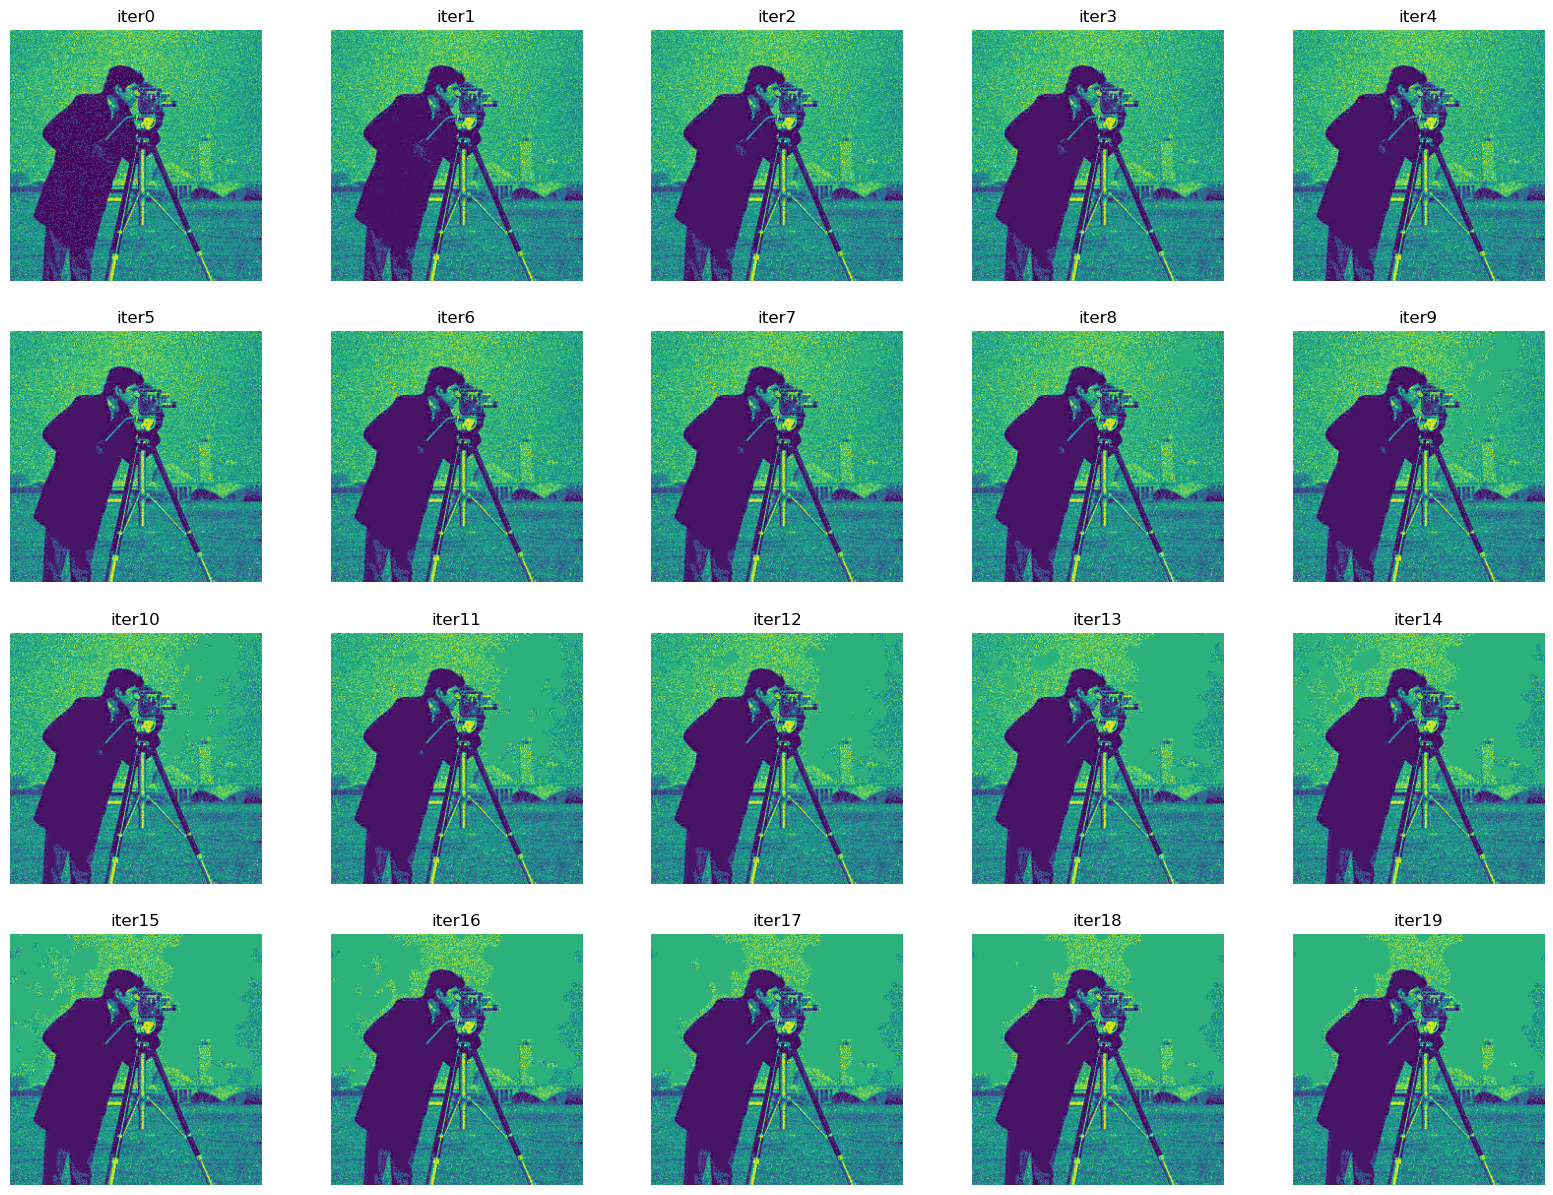

In [8]:
nrows =4
ncols= 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15),
                       sharex=True, sharey=True)
for i in range(nrows):
    for j in range(ncols):
        idx = i*5 + j*1
        ax[i,j].imshow(itered20_h10[idx])
        ax[i,j].axis('off')
        ax[i,j].set_title('iter%d'%(idx))